c:\Users\bleser\.conda\envs\floodshealth\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


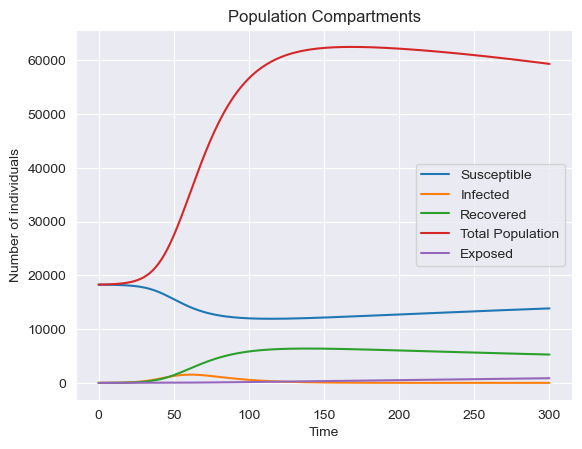

In [24]:
#SIRB infection model for V. cholera

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_ivp 

# Parameters
b = 0.000072  # natural birth rates of humans per time, fixed value
betaB = 0.5  # ingestion rate of vibrio from environment, ranges between 0.001-0.5 for cholera
betaI = 0.2  # person to person infectivity, ranges between 0.001-0.5 for cholera
d = 0.000044  # natural death rates of humans per time, fixed value
delta = 0.05  # death rate of vibrios from HI to non-HI state, ranges between 0.025 - 0.33 for cholera
eta = 0.500  # rate of infected contribution to environmental vibrio concentration, ranges between 0.0001-10 for cholera
p_gamma = 0.08  # cholera recovery rate for infecteds, ranges between 1/14 - 1/7 for cholera. Used p_ to make a distinction between inbuild function and this parameter
p_kappa = 10E6 # half saturation constant of vibrio, fixed value. Used p_ to make a distinction between inbuild function and this parameter
omega = 0.0015  # rate of waning immunity from R to S, ranges between 0.00001-1/190 for cholera


# State variables
S = np.array([18273.0]) # number of susceptible humans
I = np.array([10.0])  # number of infected humans
R = np.array([1.0])  # number of recovered humans
N = np.array([S + I + R])  # total population in all human compartments #
B = np.array([10.0])  # concentration of vibrios in environment, unit so far unknown

# Parameters and state variables as a list
parameters = [b, betaB, betaI, d, delta, eta, p_gamma, p_kappa, omega]
states = [S, I, R, N, B]

# Define time
times = np.arange(0, 301, 301)  # in days or whatever timestep is suitable

# ODE function
def proc_ode(t, y, parameters):
    S, I, R, N, B = y
    b, betaB, betaI, d, delta, eta, p_gamma, p_kappa, omega = parameters

    dS = b * N - d * S - betaB * (B * S / (p_kappa + B)) - betaI * (S * I / N) + omega * R
    dI = -d * I + betaB * (B * S / (p_kappa + B)) + betaI * (S * I / N) - p_gamma * I
    dR = -d * R + p_gamma * I - omega * R
    dB = eta * I - delta * B
    dN = dS + dI + dR

    return [dS, dI, dR, dB, dN] #N and B are constants, no derivates

# Solve the ODEs
times = np.linspace(0, 300, 301)
initial_conditions = np.ravel(states) #convert to list and make y0 one-dimensional with np.ravel
solution = solve_ivp(proc_ode, [times[0], times[-1]], initial_conditions, t_eval=times, args=(parameters,))

# Convert the solution to a DataFrame
df_solution = pd.DataFrame(solution.y.T, columns=['S', 'I', 'R', 'N', 'B'])

# Plotting
sns.set_style('darkgrid')
plt.plot(times, df_solution['S'], label='Susceptible')
plt.plot(times, df_solution['I'], label='Infected')
plt.plot(times, df_solution['R'], label='Recovered')
plt.plot(times, df_solution['N'], label='Total Population')
plt.plot(times, df_solution['B'], label='Exposed')
plt.xlabel('Time')
plt.ylabel('Number of individuals')
plt.title('Population Compartments')
plt.legend()
plt.show()